In [10]:
# import necessary packages
import skimage
from skimage import measure
import pandas as pd
import numpy as np
import os, sys
import argparse
import time
import cv2
import math
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from PIL import Image

sys.path.append('../')

# custom
from utils.GetFileNames import get_file_names

In [35]:
# specify input / output directories
img_path = '../data/train/train_images_by_pod/'
seg_path = '../data/train/train_masks_by_pod/'

# Get segmentations filenames
img_names = sorted(get_file_names(img_path, '.png'))
print('Number of segmentations:', len(img_names))

seg_names = sorted(get_file_names(seg_path, '.png'))
print('Number of segmentations:', len(seg_names))

Number of segmentations: 281
Number of segmentations: 281


In [36]:
img_names[0], seg_names[0]

('25.tt8t x fc5.B.WBP-2023.W_0.png', '25.tt8t x fc5.B.WBP-2023.W_0.png')

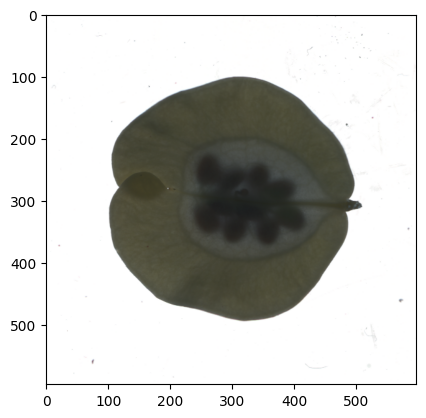

In [37]:
test_image = Image.open(img_path + img_names[0])
test_image = np.array(test_image)

test_mask = np.array(Image.open(seg_path + seg_names[0]))

plt.imshow(test_image)

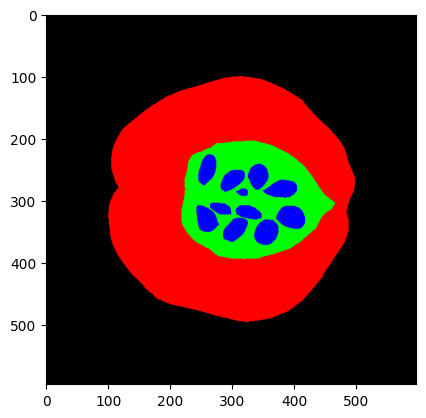

In [38]:
plt.imshow(test_mask)

In [39]:
rgb = test_image
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
r, g, b = rgb.astype(float).transpose(2, 0, 1)
h, s, v = hsv.astype(float).transpose(2, 0, 1)
l, a, B = lab.astype(float).transpose(2, 0, 1)

In [40]:
# extract color features for segmentation classes
# concat all feature maps into a tensor, index in with class label mask
features = np.stack([r, g, b, h, s, v, l, a, B], axis=-1)
features.shape

(596, 597, 9)

In [46]:
# separate out the classes
wing = test_mask[:,:,0] > 128
env = test_mask[:,:,1] > 128
seed = test_mask[:,:,2] > 128 

In [48]:
wing.sum()

86501

In [49]:
# get features by class
wing_features = features[wing] # output is (n_pixels, n_features)
env_features = features[env]
seed_features = features[seed]

wing_features.shape, env_features.shape, seed_features.shape

((86501, 9), (24642, 9), (10291, 9))

In [51]:
# aggregate features into phenotypes
wing_phenotype = wing_features.mean(axis=0)
wing_phenotype


array([ 76.59266367,  76.66958763,  60.24729194,  31.53321927,
        58.22178934,  77.27232055,  81.80275373, 124.76688131,
       137.84170125])

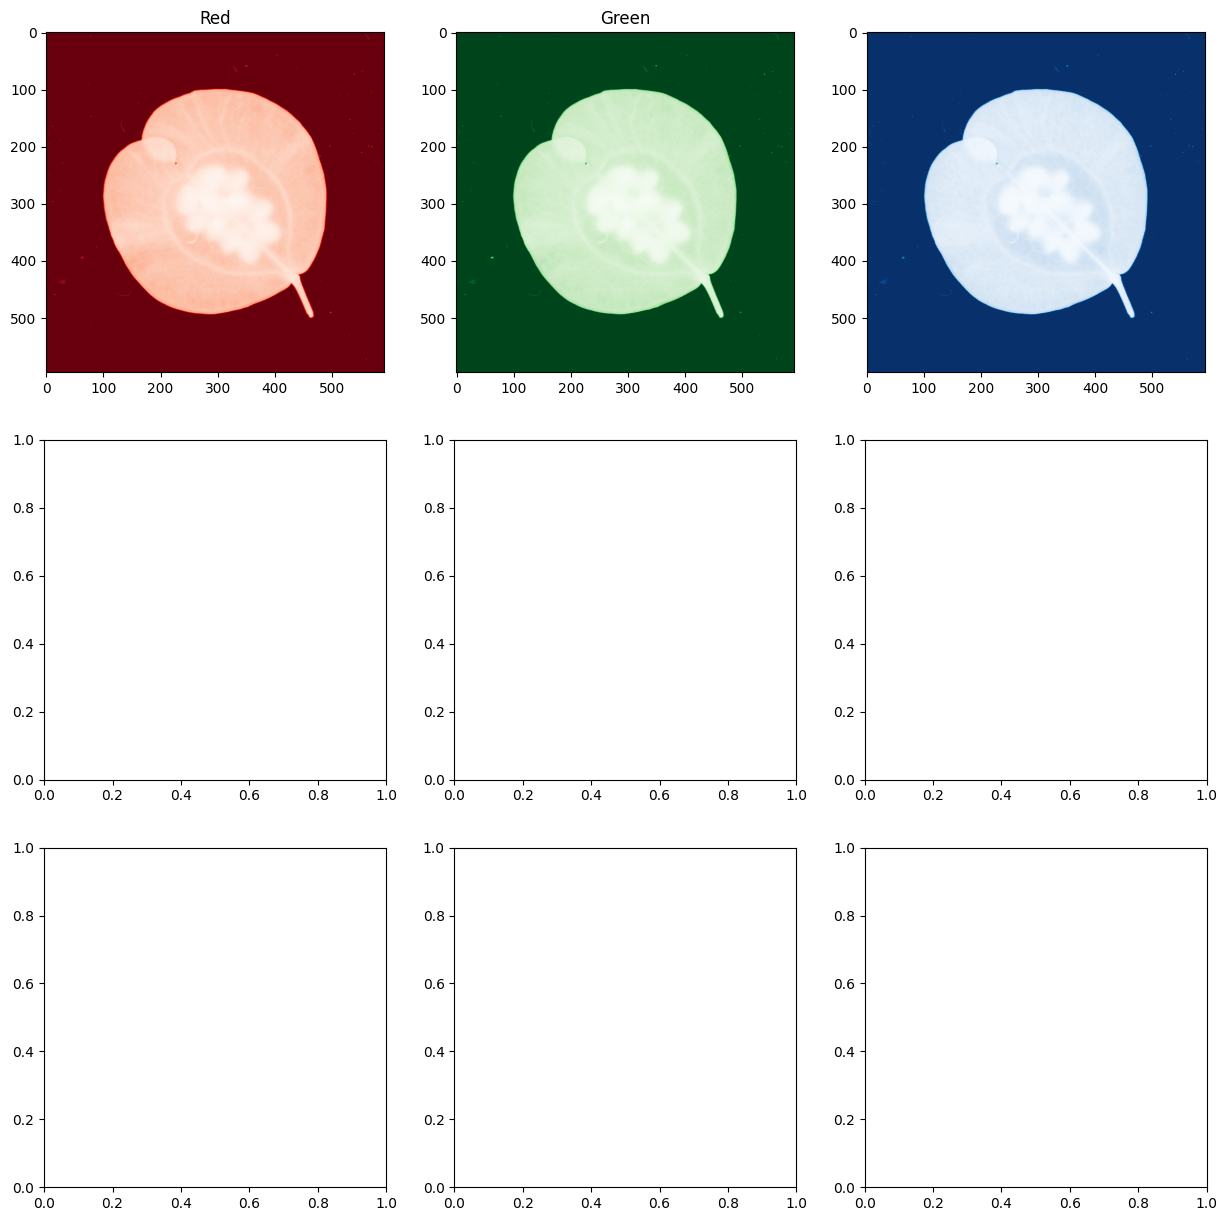

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0, 0].imshow(r, cmap='Reds')
ax[0, 0].set_title('Red')
ax[0, 1].imshow(g, cmap='Greens')
ax[0, 1].set_title('Green')
ax[0, 2].imshow(b, cmap='Blues')

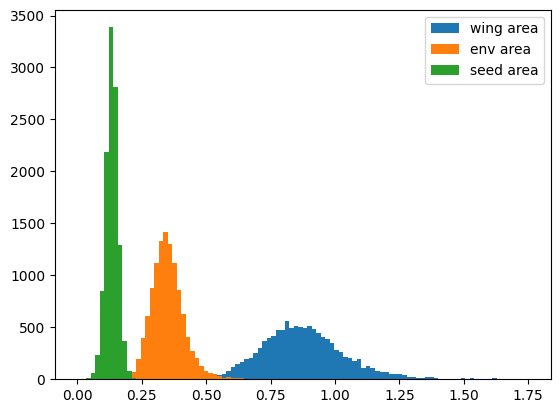

In [64]:
df = pd.read_csv("../data/pop_scale/pop_scale_segmentations_measurements/measurements.csv")
df.head()

# plt.hist(df["wing area"], bins=100);

# remove all rows with wing area < .2
df = df[df["wing area"] > .2]
plt.hist(df["wing area"], bins=100, range=(0, 1.75), label = "wing area", color = "");
plt.hist(df["env area"], bins=100, range=(0, 1.75), label = "env area", color = "");
plt.hist(df["seed area"], bins=100, range=(0, 1.75), label = "seed area", color = "");
plt.legend()

# add a legend to show the color mapping
